<h4>Thesis</h4>
<h6>These models try predict what is the final result of match, utilizing Gradient Boosting. <br>The variables X are: "home_team_cod", "away_team_cod", "B365H", "B365D", "B365A"<br>
The variables Y are: "full_time_result_cod"</h6>

<h5>Import dataset</h5>
<h6>Font: https://www.football-data.co.uk/blog/index.php<h6>

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline


pd.set_option('display.min_rows', 200)
pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 100)

df_2019_2020 = pd.read_csv("/home/felipe/Desktop/python/projects/sport-betting/premier-league/base/england-premier-league-2019-2020.csv")
df_2020_2021 = pd.read_csv("/home/felipe/Desktop/python/projects/sport-betting/premier-league/base/england-premier-league-2020-2021.csv")
df_2021_2022 = pd.read_csv("/home/felipe/Desktop/python/projects/sport-betting/premier-league/base/england-premier-league-2021-2022.csv")
df_2022_2023 = pd.read_csv("/home/felipe/Desktop/python/projects/sport-betting/premier-league/base/england-premier-league-2022-2023.csv")
df = pd.concat([df_2019_2020, df_2020_2021, df_2021_2022, df_2022_2023], axis=0)

df.rename(columns={"Date":"date", "Time":"time", "FTHG":"full_time_home_goals", "FTAG":"full_time_away_goals", "FTR":"full_time_result", 
                    "HomeTeam":"home_team", "AwayTeam":"away_team", "HTHG":"half_time_home_team_goals", 
                    "HTAG":"half_time_away_team_goals", "HTR":"half_time_result", "HS":"home_team_shots", "AS":"away_team_shots", 
                    "HST":"home_team_shots_on_target", "AST":"away_team_shots_on_target"}, inplace=True)
df.drop(columns={"Div", "Referee"}, inplace=True)
df = df.astype({"date":"datetime64"})
df = df.convert_dtypes(infer_objects=True)
df.tail()

,date,time,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,half_time_home_team_goals,half_time_away_team_goals,half_time_result,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,...,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
182,2023-01-14,15:00,Wolves,West Ham,1,0,H,0,0,D,17,16,4,4,10,7,4,3,0,2,0,0,2.63,3.30,2.70,2.65,3.3,2.65,2.65,3.25,2.70,2.75,3.29,2.82,2.62,3.20,2.70,2.63,3.1,2.70,2.80,3.41,2.83,2.70,3.27,2.75,2.20,1.67,2.28,1.69,...,0.00,1.94,1.99,1.93,1.99,1.94,1.99,1.91,1.96,2.40,3.20,3.00,2.45,3.1,3.10,2.50,3.1,3.00,2.54,3.17,3.19,2.45,3.2,3.00,2.40,3.10,3.00,2.62,3.40,3.21,2.51,3.18,3.05,2.20,1.67,2.30,1.68,2.35,1.74,2.25,1.66,-0.25,2.11,1.82,2.15,1.80,2.19,1.84,2.13,1.77
183,2023-01-14,17:30,Brentford,Bournemouth,2,0,H,1,0,H,12,7,4,2,5,9,5,3,1,1,0,0,1.65,4.00,5.25,1.63,4.0,5.25,1.65,4.00,5.25,1.69,4.14,5.23,1.63,3.90,5.25,1.62,3.8,5.25,1.71,4.35,5.55,1.66,4.09,5.20,1.80,2.00,1.88,2.02,...,-0.75,1.84,2.09,1.88,2.05,1.88,2.13,1.82,2.06,1.60,4.00,5.75,1.63,3.9,5.25,1.65,3.9,5.25,1.61,4.15,6.25,1.60,3.9,5.50,1.57,3.80,5.75,1.66,4.30,6.25,1.63,4.01,5.74,1.96,1.94,1.94,1.96,1.98,2.05,1.91,1.93,-1.00,2.00,1.80,2.08,1.85,2.17,1.89,2.09,1.79
184,2023-01-15,14:00,Chelsea,Crystal Palace,1,0,H,0,0,D,15,10,5,5,10,17,11,7,2,5,0,0,1.62,4.00,5.25,1.63,3.8,5.50,1.65,3.85,5.25,1.68,3.96,5.64,1.63,3.75,5.50,1.62,3.7,5.50,1.70,4.35,5.77,1.66,3.93,5.47,2.02,1.88,2.05,1.86,...,-0.75,1.86,2.04,1.88,2.05,1.89,2.07,1.85,2.03,1.85,3.50,4.50,1.83,3.4,4.60,1.90,3.4,4.50,1.88,3.50,4.80,1.83,3.3,4.75,1.83,3.25,4.60,1.93,3.65,4.97,1.88,3.44,4.63,2.20,1.67,2.28,1.69,2.38,1.74,2.26,1.66,-0.50,1.89,2.04,1.88,2.04,1.93,2.05,1.89,2.00
185,2023-01-15,14:00,Newcastle,Fulham,1,0,H,0,0,D,20,5,5,0,6,14,10,5,1,3,0,0,1.50,4.33,6.50,1.53,4.2,6.00,1.53,4.40,6.00,1.53,4.55,6.52,1.50,4.20,6.50,1.50,4.1,6.50,1.56,4.60,6.75,1.52,4.42,6.32,1.73,2.10,1.75,2.19,...,-1.00,1.87,2.03,1.88,2.05,1.89,2.05,1.86,2.01,1.50,4.33,6.50,1.49,4.5,6.25,1.53,4.5,6.00,1.47,4.74,7.33,1.44,4.4,7.00,1.45,4.33,6.50,1.56,4.75,7.33,1.49,4.60,6.78,1.67,2.20,1.70,2.27,1.73,2.28,1.68,2.22,-1.25,2.08,1.85,2.09,1.85,2.13,1.88,2.07,1.82
186,2023-01-15,16:30,Tottenham,Arsenal,0,2,A,0,2,A,17,14,7,5,16,15,4,3,4,2,0,0,3.10,3.60,2.20,3.30,3.6,2.10,3.20,3.55,2.20,3.34,3.71,2.21,3.25,3.50,2.15,3.20,3.4,2.15,3.38,3.85,2.24,3.24,3.63,2.18,1.80,2.00,1.83,2.07,...,0.25,1.99,1.91,2.01,1.92,2.01,1.94,1.97,1.89,3.25,3.50,2.20,3.30,3.4,2.15,3.30,3.4,2.25,3.40,3.59,2.22,3.40,3.4,2.10,3.30,3.30,2.15,3.67,3.60,2.26,3.38,3.49,2.20,1.96,1.94,1.95,1.95,2.03,2.05,1.93,1.90,0.25,2.00,1.93,2.00,1.93,2.01,1.95,1.98,1.90


<h5>Exploratory data analysis (EDA)</h5>

(1155, 104)
date                         0
time                         0
home_team                    0
away_team                    0
full_time_home_goals         0
full_time_away_goals         0
full_time_result             0
half_time_home_team_goals    0
half_time_away_team_goals    0
half_time_result             0
home_team_shots              0
away_team_shots              0
home_team_shots_on_target    0
away_team_shots_on_target    0
HF                           0
AF                           0
HC                           0
AC                           0
HY                           0
AY                           0
HR                           0
AR                           0
B365H                        0
B365D                        0
B365A                        0
BWH                          0
BWD                          0
BWA                          0
IWH                          0
IWD                          0
IWA                          0
PSH                        

<AxesSubplot:>

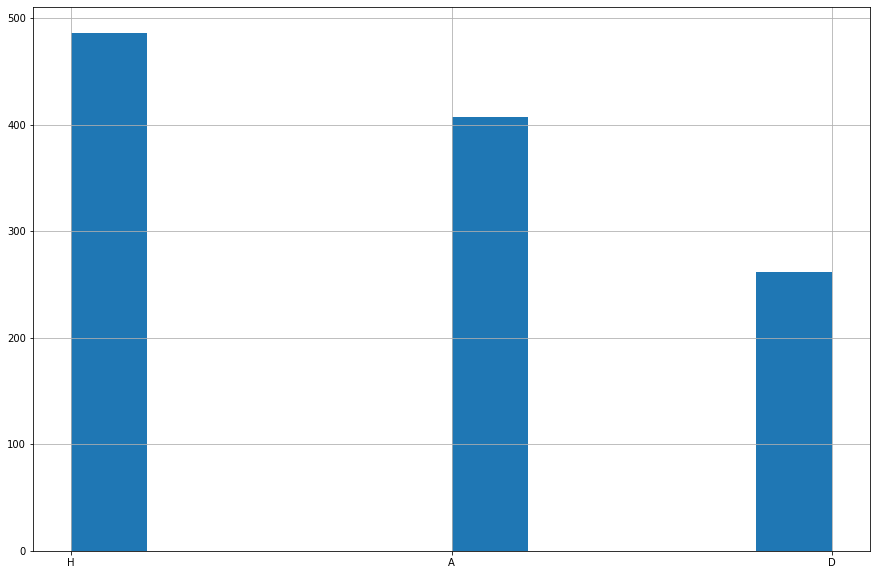

In [2]:
print(df.shape)
print(df.isna().sum())
print(df.dtypes)
print(df["home_team"].value_counts())
df["full_time_result"].hist(figsize=(15,10))

<h4>Feature Engeneering</h4>
<h6>Feature creation, Encoding</h6>

In [ ]:
# Encoding
labelencoder = LabelEncoder()
df["home_team_cod"] = labelencoder.fit_transform(df["home_team"])
df["away_team_cod"] = labelencoder.fit_transform(df["away_team"])
df["full_time_result_cod"] = labelencoder.fit_transform(df["full_time_result"])
df["half_time_result_cod"] = labelencoder.fit_transform(df["half_time_result"])
df['goal_difference'] = df['full_time_home_goals'] - df['full_time_away_goals']

# Feature creation
df["hour"] = df["time"].str.replace(":.+", "", regex=True).astype("int")
df["day_of_week"] = df["date"].dt.dayofweek
df.tail()

In [ ]:
# Create X and Y
X = df.loc[:,["home_team_cod", "away_team_cod", "B365H", "B365D", "B365A"]]
y = df.loc[:, "full_time_result_cod"]

# SelectKBest
select_kbest = SelectKBest(k="all")
fit = select_kbest.fit(X, y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
featureScores = pd.concat([df_columns, df_scores], axis=1)
featureScores.columns = ["Specs", "Score"]
featureScores.nlargest(10, "Score").set_index("Specs")
print(featureScores)

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Random Search (Hyperparameters)
model = GradientBoostingClassifier()
params = {"loss": ["deviance", "log_loss"], 
          "learning_rate": [0.1, 1], 
          "n_estimators": range(100, 500, 100), 
          "criterion": ["friedman_mse", "squared_error"]
         }
randomized_search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, cv=5, random_state=1).fit(X_train, y_train)
means = randomized_search.cv_results_["mean_test_score"]
stds = randomized_search.cv_results_["std_test_score"]
parameters = randomized_search.cv_results_["params"]
for mean, stdev, param in zip(means, stds, parameters):
    print(f"{mean} {stdev} with: {params}")
print(f"\nBest: {randomized_search.best_score_} using: {randomized_search.best_params_}\n")

# Metrics
model = GradientBoostingClassifier(**randomized_search.best_params_)
model.fit(X_train, y_train)
y_predictions = model.predict(X_test)
print(f"Parameters: {randomized_search.best_params_}")
print(f"Accuracy score (training): {model.score(X_train, y_train)}")
print(f"Accuracy score (validation): {model.score(X_test, y_test)}\n")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_predictions)}\n")
print(f"Classification Report:\n {classification_report(y_test, y_predictions)}")
